In [1]:
pip install --upgrade xgboost==2.1.1


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install optuna

# **Đọc dữ liệu**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.sql.types import IntegerType, StringType, LongType

spark = SparkSession.builder.appName("MovieLens").getOrCreate()
base_path = "/home/jovyan/data/ml-1m/"

# ===== 1. movies.dat =====
movies_raw = spark.read.text(base_path + "movies.dat")
movies_df = movies_raw.select(
    split(col("value"), "::").getItem(0).cast(IntegerType()).alias("MovieID"),
    split(col("value"), "::").getItem(1).alias("Title"),
    split(col("value"), "::").getItem(2).alias("Genres")
)

# ===== 2. ratings.dat =====
ratings_raw = spark.read.text(base_path + "ratings.dat")
ratings_df = ratings_raw.select(
    split(col("value"), "::").getItem(0).cast(IntegerType()).alias("UserID"),
    split(col("value"), "::").getItem(1).cast(IntegerType()).alias("MovieID"),
    split(col("value"), "::").getItem(2).cast(IntegerType()).alias("Rating"),
    split(col("value"), "::").getItem(3).cast(LongType()).alias("Timestamp")
)

# ===== 3. users.dat =====
users_raw = spark.read.text(base_path + "users.dat")
users_df = users_raw.select(
    split(col("value"), "::").getItem(0).cast(IntegerType()).alias("UserID"),
    split(col("value"), "::").getItem(1).alias("Gender"),
    split(col("value"), "::").getItem(2).cast(IntegerType()).alias("Age"),
    split(col("value"), "::").getItem(3).cast(IntegerType()).alias("Occupation"),
    split(col("value"), "::").getItem(4).alias("ZipCode")
)

# Kiểm tra
movies_df.show(5, truncate=False)
ratings_df.show(5)
users_df.show(5)

+-------+----------------------------------+----------------------------+
|MovieID|Title                             |Genres                      |
+-------+----------------------------------+----------------------------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |
|5      |Father of the Bride Part II (1995)|Comedy                      |
+-------+----------------------------------+----------------------------+
only showing top 5 rows

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
+------+-------+------+---------+
onl

# **TIỀN XỬ LÝ DATASET**>


In [4]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from itertools import chain

SEED = 2025  # cố định để RowID ổn định qua các lần chạy

# ===== 1) Gộp 3 bảng =====
df0 = ratings_df.join(users_df, on="UserID").join(movies_df, on="MovieID")

# ===== 2) Tạo 7 chiều =====
# AgeValue
age_map_expr = F.create_map(*list(chain.from_iterable([
    (F.lit(k), F.lit(v)) for k, v in {
        1: 15, 18: 21, 25: 29.5, 35: 39.5, 45: 47, 50: 52.5, 56: 60
    }.items()
])))
df1 = df0.withColumn("AgeValue", age_map_expr[F.col("Age")])

# OccupationScore
occupation_map_expr = F.create_map(*list(chain.from_iterable([
    (F.lit(k), F.lit(v)) for k, v in {
        0: 0, 1: 5, 2: 4, 3: 3, 4: 2, 5: 2, 6: 5, 7: 5,
        8: 1, 9: 1, 10: 1, 11: 5, 12: 4, 13: 2, 14: 3,
        15: 5, 16: 3, 17: 4, 18: 2, 19: 1, 20: 4
    }.items()
])))
df1 = df1.withColumn("OccupationScore", occupation_map_expr[F.col("Occupation")])

# MovieAge
df1 = df1.withColumn("Year", F.regexp_extract(F.col("Title"), r"\((\d{4})\)", 1).cast("int"))
max_year = df1.agg(F.max("Year")).first()[0]
df1 = df1.withColumn("MovieAge", F.lit(max_year) - F.col("Year"))

# GenreScore
df1 = df1.withColumn("GenreList", F.split(F.col("Genres"), r"\|"))
df1 = df1.withColumn(
    "GenreScore",
    F.expr("""
        aggregate(GenreList, 0.0D, (acc, g) -> acc + 
        CASE
            WHEN g = 'Action' THEN 2.0
            WHEN g = 'Comedy' THEN 2.0
            WHEN g = 'Drama' THEN 1.5
            WHEN g = 'Romance' THEN 1.3
            WHEN g = 'Sci-Fi' THEN 1.2
            WHEN g = 'Adventure' THEN 1.2
            WHEN g = 'Thriller' THEN 1.1
            WHEN g = 'Horror' THEN 0.8
            WHEN g = 'Animation' THEN 1.0
            WHEN g = 'Documentary' THEN 0.5
            ELSE 1.0
        END)
    """)
)

# MoviePopularity & MovieAvgRating
w_movie = Window.partitionBy("MovieID")
df1 = df1.withColumn("MoviePopularity", F.count(F.lit(1)).over(w_movie))
df1 = df1.withColumn("MovieAvgRating", F.avg("Rating").over(w_movie))

# UserActivity
w_user = Window.partitionBy("UserID")
df1 = df1.withColumn("UserActivity", F.count(F.lit(1)).over(w_user))

# Chỉ giữ 7 chiều
features = ["AgeValue", "OccupationScore", "MovieAge", "GenreScore",
            "MoviePopularity", "MovieAvgRating", "UserActivity"]
df_feat = df1.select(*features)

# ===== 2.5) THÊM RowID = 1..N (ORDER NUMBER, DETERMINISTIC) =====
# - Tạo cột ngẫu nhiên có seed cố định để sắp xếp ổn định
# - Tie-breaker bằng hash để xử lý trường hợp rnd trùng (rất hiếm)
df_feat = df_feat.withColumn("rnd", F.rand(seed=SEED))
tie = F.sha2(F.concat_ws("§", *[F.col(c).cast("string") for c in features]), 256)

# Lấy base 500k theo thứ tự cố định
df_origin = df_feat.orderBy(F.col("rnd").asc(), tie.asc()).limit(500000)

# Gán RowID tuần tự 1..N theo thứ tự đã cố định
w_rowid = Window.orderBy(F.col("rnd").asc(), tie.asc())
df_origin = df_origin.withColumn("RowID", F.row_number().over(w_rowid)).drop("rnd")

# ===== 4) Tạo 3 file: data_100, data_300, data_500 từ GỐC (GIỮ RowID) =====
# Dựa trên RowID để cắt slice ổn định
df_100 = df_origin.filter(F.col("RowID") <= 100000)
df_300 = df_origin.filter(F.col("RowID") <= 300000)
df_500 = df_origin  # full 500k

out_base = "/home/jovyan/output/original"
df_origin.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_origin.parquet")
df_100.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_100.parquet")
df_300.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_300.parquet")
df_500.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_500.parquet")

print(">>> File data_origin.parquet (gốc, 500k) đã lưu")
print("Số dòng:", df_origin.count())
df_origin.show(5, truncate=False)

print(">>> File data_100.parquet đã lưu (100k dòng theo RowID)")
print("Số dòng:", df_100.count())
df_100.show(5, truncate=False)

print(">>> File data_300.parquet đã lưu (300k dòng theo RowID)")
print("Số dòng:", df_300.count())
df_300.show(5, truncate=False)

print(">>> File data_500.parquet đã lưu (500k dòng, bằng data_origin)")
print("Số dòng:", df_500.count())
df_500.show(5, truncate=False)

# ===== 5) CHECK NULL CHO TỪNG FILE =====
def null_report(df, name):
    total = df.count()
    null_counts = (
        df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
          .collect()[0]
          .asDict()
    )
    print(f"\n[NULL CHECK] {name} — rows={total}")
    for c in df.columns:
        n = int(null_counts[c])
        pct = (n / total * 100.0) if total else 0.0
        print(f"  {c:<16}: {n:>8}  ({pct:6.2f}%)")
    df.show(5, truncate=False)

null_report(df_origin, "data_origin (500k)")
null_report(df_100,    "data_100 (100k)")
null_report(df_300,    "data_300 (300k)")
null_report(df_500,    "data_500 (500k)")

>>> File data_origin.parquet (gốc, 500k) đã lưu
Số dòng: 500000
+--------+---------------+--------+----------+---------------+------------------+------------+-----+
|AgeValue|OccupationScore|MovieAge|GenreScore|MoviePopularity|MovieAvgRating    |UserActivity|RowID|
+--------+---------------+--------+----------+---------------+------------------+------------+-----+
|29.5    |0              |2       |4.0       |123            |2.5528455284552845|230         |1    |
|52.5    |2              |31      |1.5       |663            |4.113122171945701 |24          |2    |
|15.0    |1              |17      |6.7       |2883           |4.022892819979188 |79          |3    |
|29.5    |4              |6       |1.5       |2227           |4.554557700942973 |1302        |4    |
|29.5    |2              |12      |2.0       |1326           |3.971342383107089 |143         |5    |
+--------+---------------+--------+----------+---------------+------------------+------------+-----+
only showing top 5 rows

>>

# **Chạy Skyline BSS trên tệp gốc**


In [5]:
# === Skyline BBS-style on multiple datasets (FAST local-first + seed prune) ===
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
from functools import reduce
from time import time
import os

# ==== Cấu hình ====
base = "/home/jovyan/output/original"
input_files = {
    "100k": "data_100.parquet",
    "300k": "data_300.parquet",
    "500k": "data_500.parquet",
}
out_dir = os.path.join(base, "skyline_bbs_results")
os.makedirs(out_dir, exist_ok=True)

features = [
    "AgeValue","OccupationScore","MovieAge","GenreScore",
    "MoviePopularity","MovieAvgRating","UserActivity"
]

# ==== Thiết lập chiều tối ưu (min = tốt) ====
min_dims = ["AgeValue", "MovieAge"]
max_dims = [c for c in features if c not in min_dims]

# ==== Tham số thực thi ====
num_partitions = 300        # bạn có thể thử 200/300/400 tuỳ cluster
seed_frac      = 0.02       # 1–2% thường đủ làm "hạt giống" prune sớm

# ==== Hàm chi phối trong min-space ====
def dominated_min(a_vec, b_vec):
    """
    True nếu a chi phối b trong min-space: a <= b mọi chiều và a < b ở ít nhất 1 chiều.
    """
    le, lt = True, False
    for ai, bi in zip(a_vec, b_vec):
        if ai > bi:
            le = False
            break
        if ai < bi:
            lt = True
    return le and lt

def part_skyline(iterator):
    """
    Skyline cục bộ trên 1 partition trong min-space.
    Mỗi element là tuple: (*features_in_min_space, RowID)
    """
    sky = []
    for row in iterator:
        v = row[:-1]  # vector features (min-space), bỏ RowID
        skip = False
        for s in sky:
            if dominated_min(s[:-1], v):
                skip = True
                break
        if skip:
            continue
        sky = [s for s in sky if not dominated_min(v, s[:-1])]
        sky.append(row)
    return iter(sky)

def early_prune_factory(seed_sky):
    """
    Trả về hàm prune sớm dùng seed skyline (min-space).
    seed_sky: list các tuple (*features_min_space, RowID)
    """
    def early_prune(iterator):
        for row in iterator:
            v = row[:-1]
            dominated_by_seed = False
            for s in seed_sky:
                if dominated_min(s[:-1], v):
                    dominated_by_seed = True
                    break
            if not dominated_by_seed:
                yield row
    return early_prune

# ==== Chạy Skyline BBS-style (FAST) cho từng file ====
for tag, fname in input_files.items():
    fpath = os.path.join(base, fname)
    print(f"\n🚀 Đang xử lý Skyline BBS-style (FAST) cho {fpath} ...")

    # 1) Load + giữ RowID có sẵn (nếu có) + ép kiểu số + đưa về min-space
    df_all = spark.read.parquet(fpath)

    has_rowid = "RowID" in df_all.columns
    select_cols = features + (["RowID"] if has_rowid else [])
    df = df_all.select(*select_cols)

    if not has_rowid:
        # Tạo RowID tạm thời (1..N) chỉ để định danh nội bộ trong phiên Skyline này
        df = df.withColumn("tmp_rand", F.rand(seed=2025))
        from pyspark.sql.window import Window
        w = Window.orderBy(F.col("tmp_rand").asc())
        df = df.withColumn("RowID", F.row_number().over(w)).drop("tmp_rand")
        print("⚠️  Cảnh báo: File không có RowID. Đã tạo RowID tạm (1..N) — KHÔNG dùng để join với pipeline khác.")

    # Ép kiểu số cho các feature
    for c in features:
        df = df.withColumn(c, F.col(c).cast("double"))

    # Đưa về min-space (đảo dấu các chiều maximize)
    for c in max_dims:
        df = df.withColumn(c, -F.col(c))

    df = df.persist(StorageLevel.MEMORY_AND_DISK)

    # 2) Lấy "seed skyline" từ mẫu (1–2%) để prune sớm
    t0 = time()
    seed_rdd = (df.sample(False, seed_frac, 2025)
                  .repartition(num_partitions)
                  .select(*features, "RowID")
                  .rdd
                  .map(lambda r: tuple([*(r[c] for c in features), r["RowID"]])))
    seed_sky = seed_rdd.mapPartitions(part_skyline).collect()
    t_seed = time() - t0
    print(f"[{tag}] 🌱 Seed skyline (from {seed_frac*100:.1f}% sample) built in {t_seed:.2f}s with {len(seed_sky)} pts")

    # 3) Prune sớm bằng seed + skyline cục bộ theo partition
    start = time()
    rdd_all = (df.select(*features, "RowID")
                 .repartition(num_partitions)
                 .rdd
                 .map(lambda r: tuple([*(r[c] for c in features), r["RowID"]])))

    rdd_pruned = rdd_all.mapPartitions(early_prune_factory(seed_sky))
    local_sky = rdd_pruned.mapPartitions(part_skyline).collect()

    # 4) Merge một lần ở driver
    final = []
    for row in local_sky:
        v = row[:-1]
        dominated_by_final = False
        for s in final:
            if dominated_min(s[:-1], v):
                dominated_by_final = True
                break
        if dominated_by_final:
            continue
        final = [s for s in final if not dominated_min(v, s[:-1])]
        final.append(row)

    elapsed = time() - start
    sky_count = len(final)
    print(f"[{tag}] ⏱️ Thời gian chạy: {elapsed:.2f} s")
    print(f"[{tag}] ⭐ Tổng số điểm skyline (BBS-style, FAST): {sky_count}")

    # 5) Tạo DataFrame kết quả để hiển thị & lưu
    rows_min = [(*r[:-1], r[-1]) for r in final]  # (*features_min_space, RowID)
    sky_min_df = spark.createDataFrame(rows_min, features + ["RowID"])
    # bbs_key: dùng tổng các toạ độ (min-space) để order hiển thị
    bbs_key = reduce(lambda acc, c: acc + F.col(c), features, F.lit(0.0))
    sky_min_df = sky_min_df.withColumn("bbs_key", bbs_key)

    # Hiển thị 10 điểm skyline đầu theo bbs_key (min-space)
    sky_min_df.orderBy("bbs_key").select(features + ["RowID"]).show(10, truncate=False)

    # 6) Trả về thang đo gốc cho các chiều maximize trước khi LƯU
    out_df = sky_min_df.drop("bbs_key")
    for c in max_dims:
        out_df = out_df.withColumn(c, -F.col(c))

    out_path = os.path.join(out_dir, f"skyline_bbs_{tag}.parquet")
    out_df.write.mode("overwrite").parquet(out_path)
    print(f"[{tag}] 💾 Đã lưu skyline vào: {out_path}")

    df.unpersist()

print("\n✅ Hoàn tất Skyline BBS-style (FAST) cho tất cả datasets.")


🚀 Đang xử lý Skyline BBS-style (FAST) cho /home/jovyan/output/original/data_100.parquet ...
[100k] 🌱 Seed skyline (from 2.0% sample) built in 4.49s with 1910 pts
[100k] ⏱️ Thời gian chạy: 7.20 s
[100k] ⭐ Tổng số điểm skyline (BBS-style, FAST): 571
+--------+---------------+--------+------------------+---------------+-------------------+------------+-----+
|AgeValue|OccupationScore|MovieAge|GenreScore        |MoviePopularity|MovieAvgRating     |UserActivity|RowID|
+--------+---------------+--------+------------------+---------------+-------------------+------------+-----+
|39.5    |-4.0           |1.0     |-3.5              |-3428.0        |-4.3173862310385065|-1595.0     |26312|
|29.5    |-4.0           |23.0    |-5.4              |-2991.0        |-4.453694416583082 |-1850.0     |7464 |
|29.5    |-4.0           |1.0     |-3.5              |-3428.0        |-4.3173862310385065|-1211.0     |13877|
|21.0    |-2.0           |1.0     |-3.5              |-3428.0        |-4.3173862310385065|-

# **Bộ dữ liệu missing (10–30%) cho từng size (100k, 300k, 500k)**

In [6]:
from pyspark.sql.functions import col, rand, when, lit
from pyspark.sql import functions as F
import os

# ==== Cấu hình ====
output_base_path = "/home/jovyan/output/original"  # thư mục chứa data gốc
missing_output_dir = os.path.join(output_base_path, "data_missing")  # folder mới cho các file missing
os.makedirs(missing_output_dir, exist_ok=True)

sizes = [100_000, 300_000, 500_000]
missing_rates = [0.10, 0.15, 0.20, 0.30]  # 10%, 15%, 20%, 30%

# Các chiều Skyline (KHÔNG gồm RowID)
skyline_cols = [
    "AgeValue", "OccupationScore", "MovieAge", "GenreScore",
    "MoviePopularity", "MovieAvgRating", "UserActivity"
]
ROW_ID_COL = "RowID"

# ==== Hàm tạo dữ liệu thiếu MCAR (KHÔNG đổi logic rand) ====
def apply_mcar_missing(df, cols, missing_rate):
    for col_name in cols:
        df = df.withColumn(
            col_name,
            when(rand() < missing_rate, lit(None)).otherwise(col(col_name))
        )
    return df

# ==== Sinh dữ liệu ====
for size in sizes:
    # Đọc lại file gốc
    base_file = os.path.join(output_base_path, f"data_{size//1000}.parquet")
    print(f"\n➡ Đang xử lý {base_file} ...")
    df_all = spark.read.parquet(base_file)

    # Chỉ chọn RowID (nếu có) + các cột skyline để tránh vô tình ghi đè cột khác
    if ROW_ID_COL in df_all.columns:
        df_base = df_all.select(*([ROW_ID_COL] + skyline_cols))
        has_rowid = True
    else:
        df_base = df_all.select(*skyline_cols)
        has_rowid = False

    for miss in missing_rates:
        rate_pct = int(miss * 100)
        print(f"   🔧 Tạo missing {rate_pct}% ...")

        # Áp dụng missing CHỈ trên các cột skyline, KHÔNG đụng RowID
        df_missing = apply_mcar_missing(df_base, skyline_cols, miss)

        # Lưu vào folder data_missing
        filename = f"data_{size//1000}k_miss{rate_pct}.parquet"
        full_path = os.path.join(missing_output_dir, filename)
        df_missing.write.mode("overwrite").parquet(full_path)
        print(f"   ✅ Đã lưu: {full_path} (missing {rate_pct}%)")

        # 👉 Hiển thị 10 dòng đầu để check nhanh (kèm RowID nếu có)
        print(f"   👀 Preview 10 dòng đầu (missing {rate_pct}%):")
        preview_cols = ([ROW_ID_COL] + skyline_cols) if has_rowid else skyline_cols
        df_missing.select(*preview_cols).show(10, truncate=False)


➡ Đang xử lý /home/jovyan/output/original/data_100.parquet ...
   🔧 Tạo missing 10% ...
   ✅ Đã lưu: /home/jovyan/output/original/data_missing/data_100k_miss10.parquet (missing 10%)
   👀 Preview 10 dòng đầu (missing 10%):
+-----+--------+---------------+--------+----------+---------------+------------------+------------+
|RowID|AgeValue|OccupationScore|MovieAge|GenreScore|MoviePopularity|MovieAvgRating    |UserActivity|
+-----+--------+---------------+--------+----------+---------------+------------------+------------+
|1    |29.5    |0              |2       |4.0       |123            |2.5528455284552845|230         |
|2    |52.5    |2              |31      |1.5       |663            |4.113122171945701 |24          |
|3    |15.0    |1              |17      |6.7       |2883           |4.022892819979188 |79          |
|4    |29.5    |4              |6       |1.5       |2227           |4.554557700942973 |NULL        |
|5    |29.5    |2              |12      |2.0       |1326           |3.

# **Huấn luyện mô hình**


In [7]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import os
import time
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from sklearn.model_selection import train_test_split
import optuna
import logging

# Tắt log INFO của Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("optuna").setLevel(logging.WARNING)

# Thư mục đầu vào & đầu ra
input_dir = "/home/jovyan/output/original/data_missing"
output_dir = "/home/jovyan/output/original/data_missing/data_imputed_xgboost"
os.makedirs(output_dir, exist_ok=True)

# Cấu hình kích thước dataset và missing rate
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Hàm chọn chunk_size tự động
def auto_chunk_size(n_rows):
    if n_rows <= 100_000:
        return None
    elif n_rows <= 300_000:
        return 150_000
    elif n_rows <= 500_000:
        return 250_000

# Xóa file cũ
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        out_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")
        if os.path.exists(out_file):
            if os.path.isdir(out_file):
                shutil.rmtree(out_file)
            else:
                os.remove(out_file)
            print(f"🗑️ Đã xóa file/folder cũ: {out_file}")

# Hàm nội suy với XGBoost
def impute_missing_data(df_missing_spark, features, targets):
    df_imputed = df_missing_spark.cache()

    for target in targets:
        df_train = df_imputed.filter(col(target).isNotNull())
        df_predict = df_imputed.filter(col(target).isNull()).select(["RowID"] + targets + features)
        if df_predict.count() == 0:
            print(f"⚠️ Không có giá trị thiếu cho {target}, bỏ qua.")
            continue

        select_cols_train = list(set(features + [target]))
        select_cols_predict = list(set(["RowID"] + features + [target]))
        train_pd = df_train.select(select_cols_train).toPandas()
        predict_pd = df_predict.select(select_cols_predict).toPandas()

        if train_pd.empty or predict_pd.empty:
            print(f"⚠️ DataFrame rỗng cho target {target}. Bỏ qua.")
            continue

        if len(train_pd) > 300_000:
            train_pd = train_pd.sample(frac=0.8, random_state=42).reset_index(drop=True)
        elif len(train_pd) > 100_000:
            train_pd = train_pd.sample(frac=0.9, random_state=42).reset_index(drop=True)

        available_cols_train = [c for c in features + [target] if c in train_pd.columns]
        available_cols_predict = [c for c in features + [target] if c in predict_pd.columns]
        if not available_cols_train or not available_cols_predict:
            print(f"⚠️ Không có cột hợp lệ cho target {target}. Bỏ qua.")
            continue

        for col_name in available_cols_train:
            train_pd[col_name] = pd.to_numeric(train_pd[col_name], errors='coerce')
        for col_name in available_cols_predict:
            predict_pd[col_name] = pd.to_numeric(predict_pd[col_name], errors='coerce')

        # Feature engineering
        for df_pd in [train_pd, predict_pd]:
            if 'AgeValue' in df_pd.columns and 'OccupationScore' in df_pd.columns:
                df_pd['Age_Occupation_Inter'] = df_pd['AgeValue'] * df_pd['OccupationScore']
            df_pd['Log_Popularity'] = np.log1p(df_pd.get('MoviePopularity', 0))
            if 'AgeValue' in df_pd.columns:
                df_pd['AgeBin'] = pd.cut(df_pd['AgeValue'], bins=[0, 25, 45, np.inf], labels=[0,1,2], include_lowest=True).cat.codes
            if 'MovieAge' in df_pd.columns:
                df_pd['MovieAgeBin'] = pd.cut(df_pd['MovieAge'], bins=[0, 10, 50, np.inf], labels=[0,1,2], include_lowest=True).cat.codes
            if 'MovieAvgRating' in df_pd.columns:
                df_pd['HighRating'] = (df_pd['MovieAvgRating'] > 4).astype(int)
            df_pd.sort_values(['AgeValue', 'MovieAge'], inplace=True, na_position='first')
            for t in targets:
                if t in df_pd.columns:
                    df_pd[f'{t}_Trend'] = (
                        df_pd[t].rolling(window=5, min_periods=1).mean()
                        .shift(1).fillna(df_pd[t].mean() if df_pd[t].notnull().any() else 0)
                    )
                else:
                    df_pd[f'{t}_Trend'] = 0

        features_ext = features + ['Age_Occupation_Inter', 'Log_Popularity', 'AgeBin', 'MovieAgeBin', 'HighRating'] + \
                       [f'{t}_Trend' for t in targets]
        safe_features = [f for f in features_ext if f in train_pd.columns and f != target]

        # Clip outlier
        clip_cols = {
            'AgeValue': (15, 60),
            'OccupationScore': (0, 5),
            'MovieAge': (0, 100),
            'GenreScore': (0, 20), 
            'MoviePopularity': (0, 10000),
            'MovieAvgRating': (1, 5),
            'UserActivity': (0, 5000)
        }
        for col_clip, (lower, upper) in clip_cols.items():
            if col_clip in train_pd.columns:
                train_pd[col_clip] = np.clip(train_pd[col_clip], lower, upper)
            if col_clip in predict_pd.columns:
                predict_pd[col_clip] = np.clip(predict_pd[col_clip], lower, upper)

        train_pd[safe_features] = train_pd[safe_features].fillna(np.nan)
        predict_pd[safe_features] = predict_pd[safe_features].fillna(np.nan)

        # Optuna tuning
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 80, 400),
                'max_depth': trial.suggest_int('max_depth', 5, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'reg_lambda': trial.suggest_float('reg_lambda', 2, 12),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 20, 50),
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
                'gamma': trial.suggest_float('gamma', 0.1, 1.0),
                'objective': 'reg:squarederror',
                'random_state': 42,
                'tree_method': 'gpu_hist' if os.environ.get("CUDA_VISIBLE_DEVICES") else 'hist',
                'enable_categorical': True,
                'n_jobs': max(1, (os.cpu_count() or 2)),
                'missing': np.nan
            }
            X_train, X_val, y_train, y_val = train_test_split(
                train_pd[safe_features], train_pd[target], test_size=0.2, random_state=42
            )
            model = XGBRegressor(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict(X_val)
            return -np.mean(np.abs(preds - y_val))

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=10, timeout=120)
        best_params = study.best_params

        # Train final model
        final_model = XGBRegressor(
            **best_params,
            objective='reg:squarederror',
            tree_method='gpu_hist' if os.environ.get("CUDA_VISIBLE_DEVICES") else 'hist',
            enable_categorical=True,
            n_jobs=max(1, (os.cpu_count() or 2)),
            missing=np.nan
        )
        final_model.fit(train_pd[safe_features], train_pd[target], verbose=False)
        preds = final_model.predict(predict_pd[safe_features])
        preds = np.clip(preds,
                        clip_cols.get(target, (-np.inf, np.inf))[0],
                        clip_cols.get(target, (-np.inf, np.inf))[1])

        predict_spark = spark.createDataFrame(pd.DataFrame({
            "RowID": predict_pd["RowID"].astype("int64"),
            f"{target}_pred": preds
        }))
        df_imputed = (
            df_imputed.join(predict_spark, "RowID", "left")
            .withColumn(target, when(col(target).isNull(), col(f"{target}_pred")).otherwise(col(target)))
            .drop(f"{target}_pred")
        )

    return df_imputed.unpersist()

# Thực hiện nội suy
features = ["AgeValue", "OccupationScore", "MovieAge", "GenreScore", "MovieAvgRating", "UserActivity"]
targets = ["AgeValue", "OccupationScore", "MovieAge", "GenreScore", "MoviePopularity", "MovieAvgRating", "UserActivity"]

t0 = time.time()
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        input_file = os.path.join(input_dir, f"data_{size//1000}k_miss{rate_int}.parquet")
        output_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")

        if not os.path.exists(input_file):
            print(f"\n⚠️ File {input_file} không tồn tại, bỏ qua.")
            continue

        print(f"\n🚀 Bắt đầu nội suy cho kích thước {size}, tỷ lệ thiếu {rate_int}%")
        start_time = time.time()
        df_missing = spark.read.parquet(input_file)
        df_imputed = impute_missing_data(df_missing, features, targets)
        df_imputed.write.mode("overwrite").parquet(output_file)
        exec_time = time.time() - start_time
        print(f"✅ Đã lưu imputed dataset vào: {output_file}")
        print(f"Hoàn tất nội suy cho kích thước {size}, tỷ lệ thiếu {rate_int}%, thời gian: {exec_time:.2f} giây")

        miss_summary = df_imputed.select([col(c).isNull().alias(c) for c in targets]).toPandas().sum()
        print("📊 Missing còn lại:", miss_summary if miss_summary.sum() > 0 else "Không còn missing")
        print("👀 Preview 10 dòng sau imputing:")
        df_imputed.select(["RowID"] + targets).show(10, truncate=False)
        print("-" * 80)

print(f"\n🏁 Tổng thời gian toàn bộ imputing: {time.time() - t0:.2f} giây")

🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss10_imputed.parquet
🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss15_imputed.parquet
🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss20_imputed.parquet
🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss30_imputed.parquet
🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_300k_miss10_imputed.parquet
🗑️ Đã xóa file/folder cũ: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_300k_miss15_imputed.parquet

🚀 Bắt đầu nội suy cho kích thước 100000, tỷ lệ thiếu 10%
✅ Đã lưu imputed dataset vào: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss10_imputed.parquet
Hoàn tất nội suy cho kích thước 100000, tỷ lệ thiếu 10%, thời gian: 124.68 giây
📊 Mi

# **SKYLINE BBS-STYLE cho các FILE ĐÃ IMPUTE**

In [13]:
# ===========================
# SKYLINE BBS-STYLE cho các FILE ĐÃ IMPUTE
# - Giữ nguyên logic: min-space, seed prune (2%), skyline cục bộ theo partition, merge ở driver
# - Đầu vào: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_{size}_miss{rate}_imputed.parquet
# - Đầu ra:  /home/jovyan/output/original/skyline_bbs_results_imputed/skyline_bbs_{size}_miss{rate}.parquet
# ===========================
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
from pyspark.sql.window import Window
from functools import reduce
from time import time
import os

# ---- Cấu hình IO ----
BASE = "/home/jovyan/output/original"
IMPUTED_DIR = os.path.join(BASE, "data_missing", "data_imputed_xgboost")  # Đã điều chỉnh để khớp với cell 5
OUT_DIR = os.path.join(BASE, "skyline_bbs_results_imputed")
os.makedirs(OUT_DIR, exist_ok=True)

# Kích thước + mức missing đã dùng khi impute
SIZES = ["100k", "300k", "500k"]
RATES = [10, 15, 20, 30]

# ---- Cấu hình Skyline ----
features = [
    "AgeValue", "OccupationScore", "MovieAge", "GenreScore",
    "MoviePopularity", "MovieAvgRating", "UserActivity"
]
# min = tốt
min_dims = ["AgeValue", "MovieAge"]
max_dims = [c for c in features if c not in min_dims]

num_partitions = 300     # thử 200/300/400 tùy tài nguyên
seed_frac      = 0.02    # 1–2% thường đủ làm seed prune sớm

# ---- Hàm hỗ trợ (giữ đúng logic) ----
def dominated_min(a_vec, b_vec):
    """
    True nếu a chi phối b trong min-space: a <= b mọi chiều và a < b ở ít nhất 1 chiều.
    """
    le, lt = True, False
    for ai, bi in zip(a_vec, b_vec):
        if ai > bi:
            le = False
            break
        if ai < bi:
            lt = True
    return le and lt

def part_skyline(iterator):
    """
    Skyline cục bộ trên 1 partition (min-space).
    Mỗi element là tuple: (*features_in_min_space, RowID)
    """
    sky = []
    for row in iterator:
        v = row[:-1]  # vector features (min-space), bỏ RowID
        skip = False
        for s in sky:
            if dominated_min(s[:-1], v):
                skip = True
                break
        if skip:
            continue
        sky = [s for s in sky if not dominated_min(v, s[:-1])]
        sky.append(row)
    return iter(sky)

def early_prune_factory(seed_sky):
    """Prune sớm bằng seed skyline (min-space)."""
    def early_prune(iterator):
        for row in iterator:
            v = row[:-1]
            dominated_by_seed = False
            for s in seed_sky:
                if dominated_min(s[:-1], v):
                    dominated_by_seed = True
                    break
            if not dominated_by_seed:
                yield row
    return early_prune

# ================== MAIN ==================
for size_key in SIZES:
    for rate in RATES:
        f_in = os.path.join(IMPUTED_DIR, f"data_{size_key}_miss{rate}_imputed.parquet")
        if not os.path.exists(f_in):
            print(f"⚠ Bỏ qua: không thấy {f_in}")
            continue

        print(f"\n🚀 Skyline BBS (imputed) → {size_key} | miss{rate}% | file: {f_in}")

        # 1) Load + đảm bảo RowID + ép kiểu + đưa về min-space
        df_all = spark.read.parquet(f_in)
        has_rowid = "RowID" in df_all.columns

        select_cols = features + (["RowID"] if has_rowid else [])
        df = df_all.select(*select_cols)

        if not has_rowid:
            # Tạo RowID tạm (1..N) chỉ để định danh nội bộ phiên Skyline này
            df = df.withColumn("tmp_rand", F.rand(seed=2025))
            w = Window.orderBy(F.col("tmp_rand").asc())
            df = df.withColumn("RowID", F.row_number().over(w)).drop("tmp_rand")
            print("⚠️  Cảnh báo: File không có RowID. Đã tạo RowID tạm (1..N) — KHÔNG dùng để join với pipeline khác.")

        # Ép kiểu số cho các feature
        for c in features:
            df = df.withColumn(c, F.col(c).cast("double"))

        # Đưa về min-space (đảo dấu các chiều maximize)
        for c in max_dims:
            df = df.withColumn(c, -F.col(c))

        df = df.persist(StorageLevel.MEMORY_AND_DISK)

        # 2) Seed skyline từ mẫu (1–2%) để prune sớm
        t0 = time()
        seed_rdd = (
            df.sample(False, seed_frac, 2025)
              .repartition(num_partitions)
              .select(*features, "RowID")
              .rdd
              .map(lambda r: tuple([*(r[c] for c in features), r["RowID"]]))
        )
        seed_sky = seed_rdd.mapPartitions(part_skyline).collect()
        t_seed = time() - t0
        print(f"🌱 Seed skyline từ {seed_frac*100:.1f}% mẫu xong trong {t_seed:.2f}s — {len(seed_sky)} điểm")

        # 3) Prune sớm + skyline cục bộ theo partition
        start = time()
        rdd_all = (
            df.select(*features, "RowID")
              .repartition(num_partitions)
              .rdd
              .map(lambda r: tuple([*(r[c] for c in features), r["RowID"]]))
        )
        rdd_pruned = rdd_all.mapPartitions(early_prune_factory(seed_sky))
        local_sky = rdd_pruned.mapPartitions(part_skyline).collect()

        # 4) Merge một lần ở driver
        final = []
        for row in local_sky:
            v = row[:-1]
            dominated_by_final = False
            for s in final:
                if dominated_min(s[:-1], v):
                    dominated_by_final = True
                    break
            if dominated_by_final:
                continue
            final = [s for s in final if not dominated_min(v, s[:-1])]
            final.append(row)

        elapsed = time() - start
        sky_count = len(final)
        print(f"⏱️ Thời gian chạy: {elapsed:.2f} s | ⭐ Skyline points: {sky_count}")

        # 5) Tạo DF kết quả & hiển thị (min-space) → rồi trả về thang đo gốc
        rows_min = [(*r[:-1], r[-1]) for r in final]  # (*features_min_space, RowID)
        sky_min_df = spark.createDataFrame(rows_min, features + ["RowID"])
        bbs_key = reduce(lambda acc, c: acc + F.col(c), features, F.lit(0.0))
        sky_min_df = sky_min_df.withColumn("bbs_key", bbs_key)

        sky_min_df.orderBy("bbs_key").select(features + ["RowID"]).show(10, truncate=False)

        # 6) Đảo dấu lại thang đo gốc & lưu file
        out_df = sky_min_df.drop("bbs_key")
        for c in max_dims:
            out_df = out_df.withColumn(c, -F.col(c))

        out_path = os.path.join(OUT_DIR, f"skyline_bbs_{size_key}_miss{rate}.parquet")
        out_df.write.mode("overwrite").parquet(out_path)
        print(f"💾 Đã lưu skyline (imputed) → {out_path}")

        df.unpersist()

print("\n✅ Hoàn tất Skyline BBS-style cho tất cả file imputed.")


🚀 Skyline BBS (imputed) → 100k | miss10% | file: /home/jovyan/output/original/data_missing/data_imputed_xgboost/data_100k_miss10_imputed.parquet
🌱 Seed skyline từ 2.0% mẫu xong trong 3.35s — 1902 điểm
⏱️ Thời gian chạy: 9.73 s | ⭐ Skyline points: 2135
+--------+------------------+-------------------+-------------------+------------------+-------------------+------------+-----+
|AgeValue|OccupationScore   |MovieAge           |GenreScore         |MoviePopularity   |MovieAvgRating     |UserActivity|RowID|
+--------+------------------+-------------------+-------------------+------------------+-------------------+------------+-----+
|52.5    |-0.0              |1.0                |-3.1116533279418945|-3100.1826171875  |-3.3217477656405165|-2314.0     |88906|
|52.5    |-0.0              |3.0                |-2.8               |-3090.80810546875 |-3.7784679089026914|-2314.0     |35046|
|52.5    |-0.0              |1.0                |-1.5               |-3071.704833984375|-4.055944055944056 

# **Tính các chỉ số đánh giá**

In [14]:
# ===========================
# SKYLINE EVAL: 12 imputed vs 3 original (ALL AS PERCENT, NO ACCURACY)
# Metrics (%): Precision = |∩|/|imp|, Recall = |∩|/|true|, F1 = 2PR/(P+R), Jaccard = |∩|/|∪|
# ===========================
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.storagelevel import StorageLevel
import os, csv

# ---- OOM-friendly tweaks ----
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)  # avoid huge broadcast
spark.conf.set("spark.sql.shuffle.partitions", "256")

BASE_DIR      = "/home/jovyan/output/original"
TRUE_SKY_DIR  = os.path.join(BASE_DIR, "skyline_bbs_results")          # skyline_bbs_{size}.parquet
IMP_SKY_DIR   = os.path.join(BASE_DIR, "skyline_bbs_results_imputed")  # skyline_bbs_{size}_miss{rate}.parquet
LOG_DIR       = os.path.join(BASE_DIR, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
CSV_OUT       = os.path.join(LOG_DIR, "skyline_eval_imputed_vs_true_percent.csv")

SIZES = ["100k", "300k", "500k"]
RATES = [10, 15, 20, 30]
KEY_COL = "RowID"

def compute_metrics(true_df, imp_df):
    """Return counts + Precision%, Recall%, F1%, Jaccard%."""
    if true_df is None or imp_df is None:
        return {"n_true":0,"n_imp":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    t = true_df.select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)
    i = imp_df.select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)

    n_true = t.count()
    n_imp  = i.count()

    if n_true == 0 and n_imp == 0:
        t.unpersist(); i.unpersist()
        return {"n_true":0,"n_imp":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    inter   = t.join(i, KEY_COL, "inner")
    n_int   = inter.count()
    union   = t.join(i, KEY_COL, "full_outer")
    n_union = union.count()

    precision = (n_int / n_imp)  if n_imp  > 0 else 0.0
    recall    = (n_int / n_true) if n_true > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
    jaccard   = (n_int / n_union) if n_union > 0 else 0.0

    t.unpersist(); i.unpersist()
    return {
        "n_true": n_true, "n_imp": n_imp, "n_int": n_int, "n_union": n_union,
        "precision_pct": precision * 100.0,
        "recall_pct":    recall * 100.0,
        "f1_pct":        f1 * 100.0,
        "jaccard_pct":   jaccard * 100.0,
    }

# ---- Global accumulators (micro over all pairs) ----
glob = {"n_true": 0, "n_imp": 0, "n_int": 0, "n_union": 0}

# prepare CSV
with open(CSV_OUT, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["size","rate","n_true","n_imp","n_intersection","n_union",
                "precision_percent","recall_percent","f1_percent","jaccard_percent"])

    # ============== MAIN LOOP ==============
    for size_key in SIZES:
        true_path = os.path.join(TRUE_SKY_DIR, f"skyline_bbs_{size_key}.parquet")
        if not os.path.exists(true_path):
            print(f"\n⚠ Bỏ qua size {size_key}: không thấy skyline thật {true_path}")
            continue

        true_df = spark.read.parquet(true_path).select(KEY_COL).dropDuplicates().cache()
        print(f"\n=== ▶ Skyline EVAL for size: {size_key} ===")
        print(f"  • True skyline: {true_path} | |true|={true_df.count()}")

        for rate in RATES:
            imp_path = os.path.join(IMP_SKY_DIR, f"skyline_bbs_{size_key}_miss{rate}.parquet")
            if not os.path.exists(imp_path):
                print(f"  ⚠ Bỏ qua rate {rate}: không thấy skyline imputed {imp_path}")
                continue

            imp_df = spark.read.parquet(imp_path).select(KEY_COL).dropDuplicates().cache()
            m = compute_metrics(true_df, imp_df)

            print(f"  • miss{rate:>2}% | |true|={m['n_true']:<6} |imp|={m['n_imp']:<6} "
                  f"|∩|={m['n_int']:<6} |∪|={m['n_union']:<6} || "
                  f"P={m['precision_pct']:.2f}%  R={m['recall_pct']:.2f}%  "
                  f"F1={m['f1_pct']:.2f}%  Jac={m['jaccard_pct']:.2f}%")

            # CSV row
            w.writerow([size_key, rate, m["n_true"], m["n_imp"], m["n_int"], m["n_union"],
                        f"{m['precision_pct']:.2f}", f"{m['recall_pct']:.2f}",
                        f"{m['f1_pct']:.2f}", f"{m['jaccard_pct']:.2f}"])

            # global accumulate (on counts)
            glob["n_true"]  += m["n_true"]
            glob["n_imp"]   += m["n_imp"]
            glob["n_int"]   += m["n_int"]
            glob["n_union"] += m["n_union"]

            imp_df.unpersist()

        true_df.unpersist()

# ---- GLOBAL SUMMARY (ALL AS %) ----
if glob["n_true"] > 0 or glob["n_imp"] > 0:
    gP   = (glob["n_int"] / glob["n_imp"])  if glob["n_imp"]  > 0 else 0.0
    gR   = (glob["n_int"] / glob["n_true"]) if glob["n_true"] > 0 else 0.0
    gF1  = (2*gP*gR)/(gP+gR) if (gP+gR) > 0 else 0.0
    gJac = (glob["n_int"] / glob["n_union"]) if glob["n_union"] > 0 else 0.0

    print("\n================== GLOBAL SUMMARY (ALL SIZES/RATES) ==================")
    print(f"Totals: |true|={glob['n_true']} |imp|={glob['n_imp']} |∩|={glob['n_int']} |∪|={glob['n_union']}")
    print(f"Precision={gP*100:.2f}%  Recall={gR*100:.2f}%  F1={gF1*100:.2f}%  Jaccard={gJac*100:.2f}%")
    print(f"\n📄 CSV saved → {CSV_OUT}")
else:
    print("\n⚠ Không có dữ liệu để tính GLOBAL metrics.")


=== ▶ Skyline EVAL for size: 100k ===
  • True skyline: /home/jovyan/output/original/skyline_bbs_results/skyline_bbs_100k.parquet | |true|=571
  • miss10% | |true|=571    |imp|=2135   |∩|=341    |∪|=2365   || P=15.97%  R=59.72%  F1=25.20%  Jac=14.42%
  • miss15% | |true|=571    |imp|=2487   |∩|=306    |∪|=2752   || P=12.30%  R=53.59%  F1=20.01%  Jac=11.12%
  • miss20% | |true|=571    |imp|=2885   |∩|=238    |∪|=3218   || P=8.25%  R=41.68%  F1=13.77%  Jac=7.40%
  • miss30% | |true|=571    |imp|=4110   |∩|=262    |∪|=4419   || P=6.37%  R=45.88%  F1=11.19%  Jac=5.93%

=== ▶ Skyline EVAL for size: 300k ===
  • True skyline: /home/jovyan/output/original/skyline_bbs_results/skyline_bbs_300k.parquet | |true|=632
  • miss10% | |true|=632    |imp|=3311   |∩|=298    |∪|=3645   || P=9.00%  R=47.15%  F1=15.12%  Jac=8.18%
  • miss15% | |true|=632    |imp|=3296   |∩|=245    |∪|=3683   || P=7.43%  R=38.77%  F1=12.47%  Jac=6.65%
  • miss20% | |true|=632    |imp|=2972   |∩|=213    |∪|=3391   || P=7.17

# **POSSIBLE SKYLINE**

In [15]:
# ============================================================
# POSSIBLE SKYLINE (min/max khớp true-skyline) trên bộ missing
# Output: parquet + CSV (Precision/Recall/F1/Jaccard %) ; preview: schema/count/head(10)
# ============================================================
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
from time import time
import os, csv

# ---------------- Spark ----------------
spark = SparkSession.builder.appName("SkylineMissingPossible_MinMax").getOrCreate()
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark.conf.set("spark.sql.shuffle.partitions", "256")

# ---------------- Config ----------------
BASE          = "/home/jovyan/output/original"
TRUE_SKY_DIR  = os.path.join(BASE, "skyline_bbs_results")   # skyline_bbs_{size_key}.parquet
MISS_DIR      = os.path.join(BASE, "data_missing")          # data_{size_key}_miss{rate}.parquet
OUT_DIR       = os.path.join(BASE, "skyline_results_possible")
LOG_DIR       = os.path.join(BASE, "logs")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
CSV_OUT       = os.path.join(LOG_DIR, "skyline_possible_vs_true_percent.csv")

# Cột tiêu chí của bạn
skyline_cols = [
    "AgeValue", "OccupationScore", "MovieAge", "GenreScore",
    "MoviePopularity", "MovieAvgRating", "UserActivity"
]
# Hướng tối ưu như script true-skyline (min 2 cột, max 5 cột)
min_dims = ["AgeValue", "MovieAge"]
max_dims = [c for c in skyline_cols if c not in min_dims]

KEY_IN   = "RowID"   # khóa gốc trong dữ liệu
KEY_USED = "ID"      # khóa chuẩn hóa nội bộ

sizes = [100_000, 300_000, 500_000]
missing_rates = [0.10, 0.15, 0.20, 0.30]  # 10, 15, 20, 30 (%)

# ---------------- Possible dominance (min-space) ----------------
def dominates_possible(row1, row2, criteria):
    """
    row1 'có thể' chi phối row2 trong min-space nếu:
      - Không có xung đột trên các tiêu chí đã biết chung (không có tiêu chí known-known mà row1 > row2),
      - Và tồn tại khả năng row1 < row2 ở ít nhất một tiêu chí
        (có thể là known-known với v1 < v2, hoặc có thiếu giúp giả định v1 < v2).
    Giả định minimize (càng nhỏ càng tốt).
    """
    conflict = False
    can_be_better = False
    for c in criteria:
        v1, v2 = row1[c], row2[c]
        if v1 is not None and v2 is not None:
            if v1 > v2:
                conflict = True
                break
            if v1 < v2:
                can_be_better = True
        else:
            # có thiếu ở ít nhất một phía → có thể gán để v1 < v2
            can_be_better = True
    return (not conflict) and can_be_better

# ---------------- Skyline (partition-local -> merge) ----------------
def skyline_possible(df, criteria, num_partitions=200):
    start = time()
    rdd = df.select([KEY_USED] + criteria).rdd.repartition(num_partitions)

    def process_partition(it):
        local_sky = []
        for row in it:
            # nếu đã có điểm local 'có thể' chi phối row → bỏ row
            if any(dominates_possible(s.asDict(), row.asDict(), criteria) for s in local_sky):
                continue
            # ngược lại: loại các điểm bị row 'có thể' chi phối
            local_sky = [s for s in local_sky if not dominates_possible(row.asDict(), s.asDict(), criteria)]
            local_sky.append(row)
        return local_sky

    part_sky = rdd.mapPartitions(process_partition).collect()

    final_sky = []
    for row in part_sky:
        if any(dominates_possible(s.asDict(), row.asDict(), criteria) for s in final_sky):
            continue
        final_sky = [s for s in final_sky if not dominates_possible(row.asDict(), s.asDict(), criteria)]
        final_sky.append(row)

    ids = [r[KEY_USED] for r in final_sky]
    elapsed = time() - start
    print(f"⏱️ Possible Skyline elapsed: {elapsed:.2f}s")

    sky_df = spark.createDataFrame([(i,) for i in ids], [KEY_USED]).join(df, KEY_USED)
    return sky_df, elapsed

# ---------------- Metrics (all as %) ----------------
def compute_metrics(true_df, pred_df, key_col=KEY_USED):
    if true_df is None or pred_df is None:
        return {"n_true":0,"n_pred":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    T = true_df.select(key_col).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)
    P = pred_df.select(key_col).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)

    n_true = T.count()
    n_pred = P.count()
    if n_true == 0 and n_pred == 0:
        T.unpersist(); P.unpersist()
        return {"n_true":0,"n_pred":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    inter   = T.join(P, key_col, "inner")
    n_int   = inter.count()
    union   = T.join(P, key_col, "full_outer")
    n_union = union.count()

    precision = (n_int / n_pred) if n_pred > 0 else 0.0
    recall    = (n_int / n_true) if n_true > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
    jaccard   = (n_int / n_union) if n_union > 0 else 0.0

    T.unpersist(); P.unpersist()
    return {
        "n_true": n_true, "n_pred": n_pred, "n_int": n_int, "n_union": n_union,
        "precision_pct": precision*100.0,
        "recall_pct":    recall*100.0,
        "f1_pct":        f1*100.0,
        "jaccard_pct":   jaccard*100.0,
    }

# ---------------- MAIN ----------------
results = []
with open(CSV_OUT, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "size","miss_rate_pct",
        "n_true","n_possible","n_intersection","n_union",
        "precision_percent","recall_percent","f1_percent","jaccard_percent",
        "time_seconds","output_parquet"
    ])

    for size in sizes:
        size_key = f"{size//1000}k"

        # True skyline path
        true_path = os.path.join(TRUE_SKY_DIR, f"skyline_bbs_{size_key}.parquet")
        if not os.path.exists(true_path):
            print(f"\n⚠️ Bỏ qua {size_key}: không thấy Skyline thật {true_path}")
            continue

        # Đọc true skyline, chuẩn hóa khóa RowID -> ID nếu cần
        true_df = spark.read.parquet(true_path)
        if KEY_USED not in true_df.columns and KEY_IN in true_df.columns:
            true_df = true_df.withColumnRenamed(KEY_IN, KEY_USED)
        true_df = true_df.select(KEY_USED).dropDuplicates().cache()
        print(f"\n=== ▶ Possible Skyline EVAL | size={size_key} | |true|={true_df.count()} ===")

        for rate in missing_rates:
            rate_int = int(rate * 100)

            # Input missing
            miss_path = os.path.join(MISS_DIR, f"data_{size_key}_miss{rate_int}.parquet")
            if not os.path.exists(miss_path):
                print(f"  ⚠️ Bỏ qua miss{rate_int}%: không thấy {miss_path}")
                continue

            print(f"\n📂 File missing: {miss_path}")
            df_miss = spark.read.parquet(miss_path).cache()

            # Chuẩn hóa khóa: RowID -> ID
            if KEY_USED not in df_miss.columns and KEY_IN in df_miss.columns:
                df_miss = df_miss.withColumnRenamed(KEY_IN, KEY_USED)

            # Ép kiểu số cho các tiêu chí (nếu tồn tại)
            for c in skyline_cols:
                if c in df_miss.columns:
                    df_miss = df_miss.withColumn(c, F.col(c).cast("double"))

            # ---------- PREVIEW: chỉ show vài dòng ----------
            cols_now = df_miss.columns
            total_cnt = df_miss.count()
            print(f"👉 Schema: {cols_now}")
            print(f"👉 Tổng dòng: {total_cnt}")
            preview_cols = [KEY_USED] + [c for c in skyline_cols if c in cols_now]
            print(f"👉 Preview 10 dòng đầu (size={size_key}, miss={rate_int}%):")
            df_miss.select(*preview_cols).show(10, truncate=False)

            # ---------- ĐƯA VỀ MIN-SPACE (đảo dấu các chiều maximize) ----------
            for c in max_dims:
                if c in df_miss.columns:
                    df_miss = df_miss.withColumn(c, -F.col(c))

            # ---------- RUN POSSIBLE SKYLINE TRONG MIN-SPACE ----------
            sky_possible_min, elapsed = skyline_possible(df_miss, skyline_cols, num_partitions=200)
            possible_cnt = sky_possible_min.select(KEY_USED).dropDuplicates().count()

            # ---------- TRẢ VỀ THANG ĐO GỐC (đảo lại dấu các max-dims) ----------
            sky_out = sky_possible_min
            for c in max_dims:
                if c in sky_out.columns:
                    sky_out = sky_out.withColumn(c, -F.col(c))

            # Lưu parquet (ghi đè)
            out_parquet = os.path.join(OUT_DIR, f"data_{size_key}_miss{rate_int}_skyline.parquet")
            sky_out.write.mode("overwrite").parquet(out_parquet)
            print(f"    💾 Saved: {out_parquet} | |possible|={possible_cnt} | time={elapsed:.2f}s")

            # Metrics vs true (%, dùng ID)
            m = compute_metrics(true_df, sky_possible_min.select(KEY_USED).dropDuplicates(), key_col=KEY_USED)
            print(f"    📐 P={m['precision_pct']:.2f}%  R={m['recall_pct']:.2f}%  "
                  f"F1={m['f1_pct']:.2f}%  Jaccard={m['jaccard_pct']:.2f}%  "
                  f"|∩|={m['n_int']} |∪|={m['n_union']}")

            # Ghi CSV
            w.writerow([
                size_key, rate_int,
                m["n_true"], possible_cnt, m["n_int"], m["n_union"],
                f"{m['precision_pct']:.2f}", f"{m['recall_pct']:.2f}",
                f"{m['f1_pct']:.2f}", f"{m['jaccard_pct']:.2f}",
                f"{elapsed:.2f}", out_parquet
            ])

            # Tóm tắt cuối
            results.append((
                size_key, f"{rate_int}%", m["n_true"], possible_cnt,
                m["precision_pct"], m["recall_pct"], m["f1_pct"], m["jaccard_pct"], elapsed
            ))

            df_miss.unpersist()

        true_df.unpersist()

# ---------------- Console summary ----------------
print("\n📊 POSSIBLE vs TRUE (%, by size & miss%):")
print("Dataset | Missing | |true| |possible| |  P(%)  |  R(%)  |  F1(%) | Jacc(%) | Time(s)")
print("-"*96)
for r in results:
    size_key, miss_pct, n_true, n_possible, P, R, F1, J, t = r
    print(f"{size_key:<7} | {miss_pct:<7} | {n_true:<6} | {n_possible:<9} | "
          f"{P:7.2f} | {R:7.2f} | {F1:7.2f} | {J:7.2f} | {t:7.2f}")

print(f"\n📄 CSV saved → {CSV_OUT}")


=== ▶ Possible Skyline EVAL | size=100k | |true|=571 ===

📂 File missing: /home/jovyan/output/original/data_missing/data_100k_miss10.parquet
👉 Schema: ['ID', 'AgeValue', 'OccupationScore', 'MovieAge', 'GenreScore', 'MoviePopularity', 'MovieAvgRating', 'UserActivity']
👉 Tổng dòng: 100000
👉 Preview 10 dòng đầu (size=100k, miss=10%):
+---+--------+---------------+--------+----------+---------------+------------------+------------+
|ID |AgeValue|OccupationScore|MovieAge|GenreScore|MoviePopularity|MovieAvgRating    |UserActivity|
+---+--------+---------------+--------+----------+---------------+------------------+------------+
|1  |29.5    |0.0            |2.0     |4.0       |123.0          |2.5528455284552845|230.0       |
|2  |52.5    |2.0            |31.0    |1.5       |663.0          |4.113122171945701 |24.0        |
|3  |15.0    |1.0            |17.0    |6.7       |2883.0         |4.022892819979188 |79.0        |
|4  |29.5    |4.0            |6.0     |1.5       |2227.0         |4.5545

# **Chart biểu diễn**

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/combined_overlay_f1.png


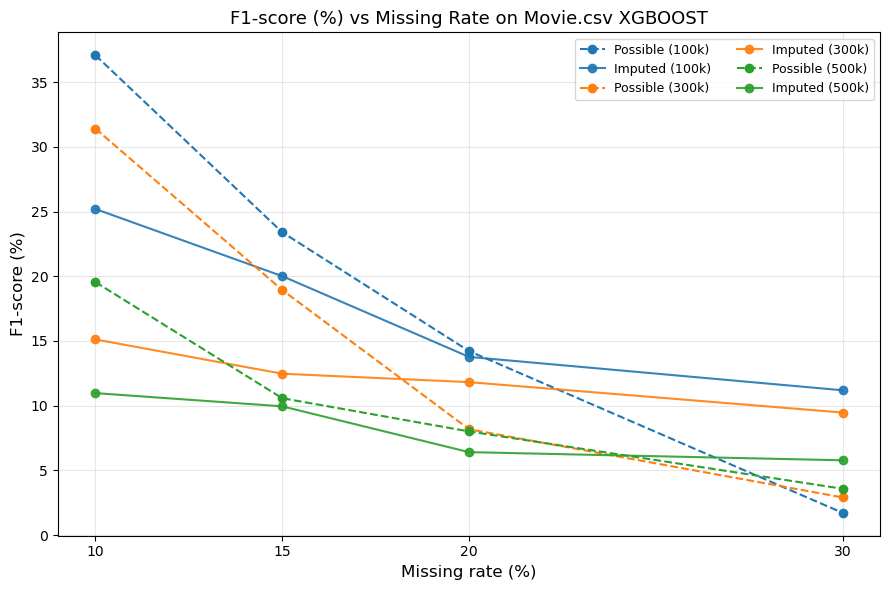

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/combined_overlay_jaccard.png


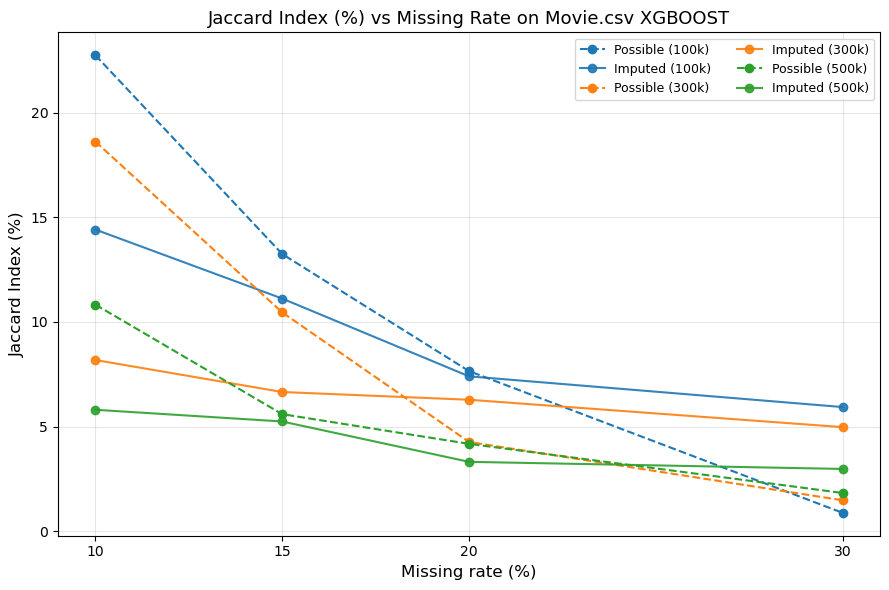


🎉 Charts saved to: /home/jovyan/output/original/logs/chart_bounded


In [16]:
# ============================================================
# 📊 Combined Overlay Chart — F1 & Jaccard (no shaded area)
#  ✅ Hiển thị trực tiếp + Lưu file PNG vào /home/jovyan/output/original/logs/chart_bounded
# ============================================================
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- Directories --------
BASE_LOG = "/home/jovyan/output/original/logs"
CSV_POSSIBLE = os.path.join(BASE_LOG, "skyline_possible_vs_true_percent.csv")
CSV_IMPUTED  = os.path.join(BASE_LOG, "skyline_eval_imputed_vs_true_percent.csv")
OUT_DIR = os.path.join(BASE_LOG, "chart_bounded")
os.makedirs(OUT_DIR, exist_ok=True)

# -------- Load CSVs & normalize columns --------
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    if "miss_rate_pct" not in df.columns:
        for k in ["rate", "missing_rate", "missing_rate_pct"]:
            if k in df.columns:
                df = df.rename(columns={k: "miss_rate_pct"})
                break
    for old, new in {"f1_pct": "f1_percent", "jaccard_pct": "jaccard_percent"}.items():
        if old in df.columns:
            df = df.rename(columns={old: new})
    for c in ["miss_rate_pct", "f1_percent", "jaccard_percent"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "size" in df.columns:
        df["size"] = df["size"].astype(str)
    return df

df_pos = load_csv(CSV_POSSIBLE)
df_imp = load_csv(CSV_IMPUTED)

sizes = ["100k", "300k", "500k"]
rate_order = [10, 15, 20, 30]

# -------- Color palette --------
palette = {
    "100k": "#1f77b4",  # blue
    "300k": "#ff7f0e",  # orange
    "500k": "#2ca02c",  # green
}

# -------- Function to plot overlay & save --------
def overlay_plot(metric_col, ylabel, fname):
    plt.figure(figsize=(9,6))

    for sz in sizes:
        p = df_pos[(df_pos["size"] == sz) & (df_pos["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]
        i = df_imp[(df_imp["size"] == sz) & (df_imp["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]
        mg = pd.merge(
            p.rename(columns={metric_col: "possible"}),
            i.rename(columns={metric_col: "imputed"}),
            on="miss_rate_pct",
            how="inner"
        ).sort_values("miss_rate_pct")

        if mg.empty:
            print(f"[⚠] No overlap for {sz} - {metric_col}")
            continue

        x = mg["miss_rate_pct"].values
        yU = mg["possible"].values
        yM = mg["imputed"].values
        c = palette[sz]

        # Plot lines: Possible (dashed) & Imputed (solid)
        plt.plot(x, yU, "o--", color=c, label=f"Possible ({sz})")
        plt.plot(x, yM, "o-",  color=c, alpha=0.9, label=f"Imputed ({sz})")

    plt.xlabel("Missing rate (%)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f"{ylabel} vs Missing Rate on Movie.csv XGBOOST", fontsize=13)
    plt.xticks(rate_order)
    plt.grid(alpha=0.3)
    plt.legend(ncol=2, fontsize=9, loc="best")
    plt.tight_layout()

    # ✅ Save figure
    out_path = os.path.join(OUT_DIR, fname)
    plt.savefig(out_path, dpi=200)
    print(f"✅ Saved chart → {out_path}")

    # ✅ Show on Jupyter
    plt.show()

# -------- Generate & display both charts --------
overlay_plot("f1_percent", "F1-score (%)", "combined_overlay_f1.png")
overlay_plot("jaccard_percent", "Jaccard Index (%)", "combined_overlay_jaccard.png")

print("\n🎉 Charts saved to:", OUT_DIR)

In [12]:
import shutil
import os

# Thư mục cần zip
OUT_DIR = "/home/jovyan/output"

# File zip đầu ra (phải là file, không phải thư mục)
zip_path = "/home/jovyan/output/output_folder.zip"

# Nếu file zip đã tồn tại, xóa đi
if os.path.exists(zip_path):
    os.remove(zip_path)

# Tạo zip
shutil.make_archive(base_name=zip_path.replace('.zip',''), format='zip', root_dir=OUT_DIR)

print(f"✅ Đã zip thư mục {OUT_DIR} → {zip_path}")


✅ Đã zip thư mục /home/jovyan/output → /home/jovyan/output/output_folder.zip
